# **The Great La Palma Bird Challenge!** 🐦

For this Bird Challenge, we would like you to configure and set up an AudioMoth in a location that you think will capture the greatest number of bird species.

Using the tips in your [Field Guide](https://) you should hopefully have collected data over the past 48 hours which is now ready for analysis.

So let's get started.

### Bioacoustic monitoring

As we have seen earlier, **Bioacoustic sensors** such as AudioMoths, can be used to collect field recordings of animal sounds.

Usually, these sensors are deployed statically in the field for a long periods of time and record sounds continuously. This is called **passive acoustic monitoring**.

<img alt="passive acoustic monitoring" width="400" src="https://wittmann-tours.de/wp-content/uploads/2018/06/AudioMoth.jpg"></img>

Alternatively, recordings are actively directed towards a specific animal species or sound events.

<img alt="active recording" width="400" src="https://s3.amazonaws.com/cdn.freshdesk.com/data/helpdesk/attachments/production/48032687175/original/xjI7Dy3Q9kaCZinr5vf4ksNxQbjK13Yv3A.jpg?1584552543"></img>

> Taken from the Macaulay Library blog post:
> [Sound recording tips](https://support.ebird.org/en/support/solutions/articles/48001064298-sound-recording-tips)

Currently, bioacoustic methods are mainly used for **species presence/absence** detection and can be especially useful for cryptic species detection.

## **Setup**

Make sure to use GPU runtime in Colab.

Go to Runtime -> Change runtime type and select GPU as the hardware accelerator



#### Mount your Google Drive

In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


####We'll install our dependencies here

In [13]:
!pip install -q birdnetlib
from birdnetlib import Recording
from birdnetlib.analyzer import Analyzer
from datetime import datetime
!pip install -q matplotlib pydub
import os
from os import listdir
from os.path import isfile, join
import random
import matplotlib.pyplot as plt
from pydub import AudioSegment
from pydub.playback import play
from scipy.io import wavfile
from IPython.display import display, HTML, Audio
import librosa
import numpy as np
import soundfile as sf
from tqdm import tqdm
from collections import Counter, defaultdict


#### Link to your audio data folder - the parent folder



In [4]:
# This specifies the folder
audio_filepath = "/content/drive/MyDrive/20240201"

# This identifies the audio files in the folder
wav_files = [os.path.join(audio_filepath, file) for file in os.listdir(audio_filepath) if file.endswith('.WAV')]


### Select a random recording from your audio folder and plot a **spectrogram** of it

We can use a **spectrogram** to decompose the sound into **frequencies** and visualise them as a 2D image.

The x-axis is time, y-axis is frequency and the depth of colour represents the amplitude.

In [2]:
# Select a random file
sample_file = random.choice(wav_files)

NameError: name 'random' is not defined

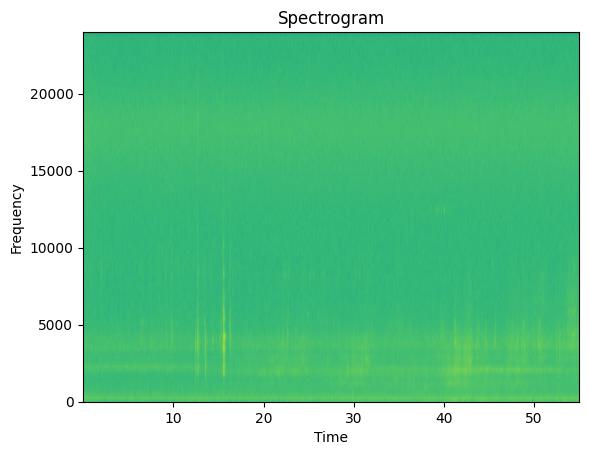

In [5]:
def plot_spectrogram(audio_file):
    rate, data = wavfile.read(audio_file)
    plt.specgram(data, Fs=rate)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title('Spectrogram')
    plt.show()

plot_spectrogram(sample_file)

Spectrograms are used by bioacousticians to quickly spot and identify familiar species **visually**.

Most modern AI detection algorithms used to automatically classify species from animal vocalisations also use spectrograms as their training data. These are primarily Convolutional Neural Networks used in image classification such as reCaptcha forms.



### Let's have a listen

In [6]:
Audio(sample_file)

Output hidden; open in https://colab.research.google.com to view.

### Any idea what the species is??


####Feel free to record your answer below
If the recording didn't seem to pick up any bird song then you could re-run the random.choice code to select a new sample and try again.

### Let's see what BirdNet thinks

We're going to run our sample recording via BirdNet which will detect any matching species in each 3 second input and recording a confidence metric for its detection.

We typically set a minimum confidence threshold to improve accuracy.

In [1]:
# Load and initialize the BirdNET-Analyzer models.
analyzer = Analyzer()

recording = Recording(
    analyzer,
    sample_file,
    lat=55.3781,  # Are these correct for La Palma?
    lon=3.4360,   # Are these correct for La Palma?
    date=datetime(year=2022, month=5, day=10),  # Use date or week_48
    min_conf=0.6, # feel free to adjust this up or down and see how that affects detections
)
recording.analyze()

# Initialize a string to hold the formatted output
output = "<strong>Detected bird species:</strong><br>"

# Check if there are any detections
if recording.detections:
    # Iterate through detections and format each one
    for idx, detection in enumerate(recording.detections, start=1):
        output += f"<span style='color:green'><strong>{idx}. {detection['common_name']} - {detection['scientific_name']} - Confidence: {detection['confidence']}</strong></span><br>"
else:
    output += "<span style='color:red'><strong>No bird species detected.</strong></span>"

# Display the formatted output using HTML
display(HTML(output))


NameError: name 'Analyzer' is not defined

Did you guess right? **BirdNet** splits the recording into **3 second chunks** and detects species within each chunk. All detections above the minimum confidence threshold (**min_conf**) will be listed.

If you didn't get any detections, try adjusting the min_conf to a lower setting, checking the Lat/Lon coordinates are correct or selecting a new random_sample.

## Onwards to the Challenge!

Now let's import all of the audio files we've collected and run BirdNet on all of them.

You should start to see some detections popping up in the output as BirdNet processes them all.

This will take some time...check the progress bar for an estimate of exactly how long.

In the meantime, why not take a look at all the birds you could have detected: [Birds of La Palma](https://avibase.bsc-eoc.org/checklist.jsp?region=ESicpa&list=howardmoore)

In [11]:
def split_audio(audio_file_path, chunk_size=3):
    y, sr = librosa.load(audio_file_path, sr=None)
    chunk_length = sr * chunk_size
    chunks = [y[i:i + chunk_length] for i in range(0, len(y), chunk_length)]
    return chunks, sr

def analyze_chunks(analyzer, chunks, sr, lat, lon, date, min_conf=0.8):
    results = []
    for i, chunk in enumerate(chunks):
        # Save chunk as WAV file
        chunk_file_path = f'chunk_{i}.wav'
        sf.write(chunk_file_path, chunk, sr)

        # Call BirdNET on the chunk_file_path
        recording = Recording(
            analyzer,
            chunk_file_path,
            lat=lat,
            lon=lon,
            date=date,
            min_conf=min_conf,
        )
        recording.analyze()
        results.append({
            'chunk_number': i,
            'detections': recording.detections
        })

    return results

if __name__ == "__main__":

    # Load and initialize the BirdNET-Analyzer models.
    analyzer = Analyzer()

    # Dictionary to store results for each audio file
    all_results = {}

    for audio_filename in wav_files:
        audio_filepath = join(audio_filepath, audio_filename)

        # Split audio into chunks
        chunks, sr = split_audio(audio_filepath)

        # Specify location and date information
        lat = 55.3781
        lon = 3.4360
        date = datetime(year=2022, month=5, day=10)

        # Analyze each chunk
        results = []

        # Initialize tqdm progress bar with the total number of chunks
        progress_bar = tqdm(total=len(chunks), desc=f"Processing {audio_filename}", unit="chunk")

        for result in analyze_chunks(analyzer, chunks, sr, lat, lon, date):
            results.append(result)
            progress_bar.update(1)  # Update progress bar for each chunk processed

        progress_bar.close()  # Close the tqdm progress bar

        # Store results in the dictionary
        all_results[audio_filename] = results

        # Print or process the results as needed
        for result in results:
            print(f"File: {audio_filename}, Chunk {result['chunk_number']} Detections: {result['detections']}")

Streaming output truncated to the last 5000 lines.
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 ch

## Let's visualise the results

We're now going to plot the species on two axes: number of detections (y-axis) and average confidence per species detection (z-axis). Note the scale of the z-axis - which will typically start from the min_confidence threshold you defined (so seemingly low values may actually be quite high)

<ipython-input-14-1b569ce6f2ed>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(species_names,rotation=45)


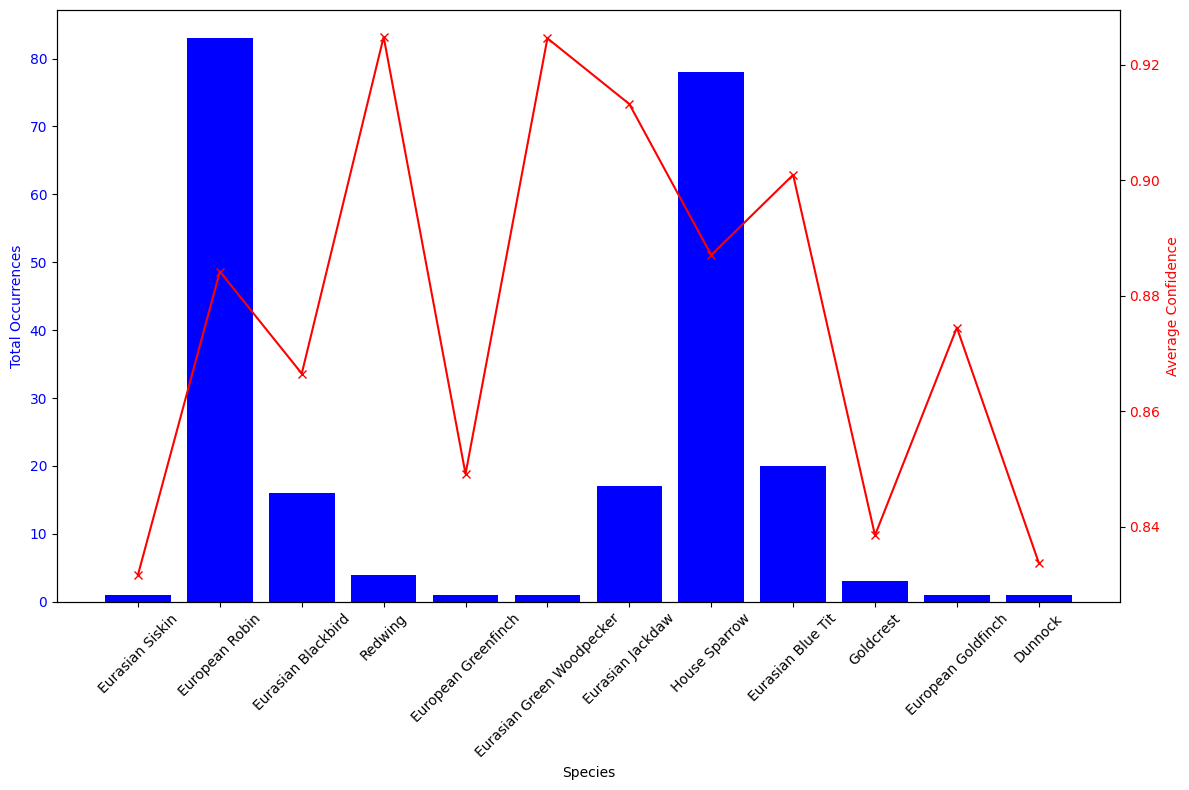

In [14]:
def plot_results(all_results):
    # Identify all unique species across chunks
    all_species = set()

    # Initialize counters for total occurrences and total confidence for each species
    species_counter = Counter()
    species_confidence = defaultdict(float)

    for results in all_results.values():
        for result in results:
            detections = result['detections']
            for detection in detections:
                common_name = detection['common_name']
                confidence = detection['confidence']

                # Add the species to the set of all species
                all_species.add(common_name)

                # Increment the count and add confidence for the species
                species_counter[common_name] += 1
                species_confidence[common_name] += confidence

    # Calculate average confidence for each species
    avg_confidence = {species: species_confidence[species] / species_counter[species] for species in all_species}

    # Get data for plotting
    species_names, total_counts = zip(*species_counter.items())
    avg_confidences = [avg_confidence.get(species, 0) for species in species_names]

    # Plot 2D bar chart
    fig, ax1 = plt.subplots(figsize=(12, 8))

    ax1.bar(species_names, total_counts, color='blue', label='Total Occurrences')
    ax1.set_xlabel('Species')
    ax1.set_xticklabels(species_names,rotation=45)
    ax1.set_ylabel('Total Occurrences', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(species_names, avg_confidences, 'rx-', label='Average Confidence')
    ax2.set_ylabel('Average Confidence', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    fig.tight_layout()
    plt.show()

# Plot!
plot_results(all_results)


We know how condfident BirdNet is about its results, but how confident are we that it's detected correctly? We can obtain playback samples of different confidence levels per species to 'ground truth' some of its classifications.: